# 5장 Deep CNN

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no suc

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
import ipdb

## Recycles image classification

### Pytorch custom 데이터셋 클래스

In [ ]:
# class PyTorch_Custom_Dataset_Class(Dataset):
#     def __init__(self):
#         super().__init__()
#         self.number = [i for i in range(10)]
#     def __getitem__(self, idx):
#         print("__getitem__ 실행")
#         return self.number[idx]
#     def __len__(self):
#         print("__len__ 실행")
#         return len(self.number)
#     def __str__(self):
#         print("Hello") 

In [16]:
%%writefile Dataset_Class.py

import os
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import shutil

class PyTorch_Classification_Dataset_Class(Dataset):
    def __init__(self
                # , dataset_dir = "/content/Recycle_Classification_Dataset"
                # , dataset_dir = "Recycle_Classification_Dataset"
                , dataset_dir
                , transform):
        super().__init__()
        # if not os.path.isdir(dataset_dir):
        #     os.system("git clone https://github.com/JinFree/Recycle_Classification_Dataset.git") # 
        #     # os.system("rm -rf ./Recycle_Classification_Dataset/.git")
        #     # shutil.rmtree("./Recycle_Classification_Dataset/.git")
        #     shutil.rmtree(os.path.join(os.getcwd(), "Recycle_Classification_Dataset", ".git"))

        self.image_abs_path = dataset_dir
        self.transform = transform
        # if self.transform is None:
        #     self.transform = transforms.Compose([
        #             transforms.Resize(256)
        #             , transforms.RandomCrop(224)
        #             , transforms.ToTensor()
        #             , transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
        #             ])
        self.label_list = os.listdir(self.image_abs_path) # ["can", "glass", "paper", "plastic"]
        self.label_list.sort()
        self.x_list = []
        self.y_list = []
        for label_index, label_str in enumerate(self.label_list):
            img_path = os.path.join(self.image_abs_path, label_str)  # ~/Recycle_Classification_Dataset
            img_list = os.listdir(img_path)
            for img in img_list:
                self.x_list.append(os.path.join(img_path, img))
                self.y_list.append(label_index)

    def __len__(self):
        return len(self.x_list)

    def __getitem__(self, idx):
        image = Image.open(self.x_list[idx])
        if image.mode != "RGB":
            image = image.convert('RGB')
        # if self.transform is not None:
        image = self.transform(image)
        return image, self.y_list[idx]

    def __save_label_map__(self, dst_text_path = "label_map.txt"):
        label_list = self.label_list
        f = open(dst_text_path, 'w')
        for i in range(len(label_list)):
            f.write(label_list[i]+'\n')
        f.close()

    def __num_classes__(self):
        return len(self.label_list)

Overwriting Dataset_Class.py


### Model from scratch

In [13]:
%%writefile Model_Class_From_the_Scratch.py

import torch
import torch.nn as nn
import torch.nn.functional as F


class MODEL_From_Scratch(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
            , nn.BatchNorm2d(32)
            , nn.ReLU()
            , nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
            , nn.BatchNorm2d(64)
            , nn.ReLU()
            , nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
            , nn.BatchNorm2d(128)
            , nn.ReLU()
            , nn.AdaptiveAvgPool2d(1)
            , nn.Flatten()
            , nn.Linear(128, 512)
            , nn.ReLU()
            , nn.Dropout()
            , nn.Linear(512, 64)
            , nn.ReLU()
            , nn.Dropout()
            , nn.Linear(64, num_classes)
            # , nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.classifier(x)

Overwriting Model_Class_From_the_Scratch.py


In [ ]:
# dataset = PyTorch_Classification_Dataset_Class()
# print(len(dataset))
# dataset.__save_label_map__()
# print("class number = ", dataset.__num_classes__())

###  MobileNet class

In [22]:
%%writefile Model_Class_Transfer_Learning_MobileNet.py

import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class MobileNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V2
        self.network = models.mobilenet_v2(weights=weights)
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier[1] = nn.Linear(num_ftrs, num_classes)
        # self.classifier = nn.Softmax(dim=-1)
   


    def forward(self, x):
        x = self.network(x)
        # x = self.classifier(x)
        return x

Overwriting Model_Class_Transfer_Learning_MobileNet.py


### Training class

In [ ]:
# %%writefile PyTorch_Classification_Training_Class.py

import os
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import shutil

# from .Model_Class_From_the_Scratch import MODEL_From_Scratch
# from .Model_Class_Transfer_Learning_MobileNet import MobileNet
# from .Dataset_Class import PyTorch_Classification_Dataset_Class as Dataset

# window
from Model_Class_From_the_Scratch import MODEL_From_Scratch
from Model_Class_Transfer_Learning_MobileNet import MobileNet
from Dataset_Class import PyTorch_Classification_Dataset_Class as Dataset


class PyTorch_Classification_Training_Class():
    def __init__(self
                # , dataset_dir = "/content/Recycle_Classification_Dataset"
                # , dataset_dir = "./Recycle_Classification_Dataset" # window
                 , dataset_dir = os.path.join(os.getcwd(), "Recycle_Classification_Dataset")
                , batch_size = 16
                , train_ratio = 0.75
                ):
        if not os.path.isdir(dataset_dir):
            os.system("git clone https://github.com/JinFree/Recycle_Classification_Dataset.git")
            # os.system("rm -rf ./Recycle_Classification_Dataset/.git")
            shutil.rmtree(os.path.join(os.getcwd(), "Recycle_Classification_Dataset", ".git"))
            # dataset_dir = os.path.join(os.getcwd(), 'Recycle_Classification_Dataset')
        self.USE_CUDA = torch.cuda.is_available()
        self.DEVICE = torch.device("cuda" if self.USE_CUDA else "cpu")
        self.transform = transforms.Compose([
                transforms.Resize(256)
                , transforms.RandomCrop(224)
                , transforms.ToTensor()
                , transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
                ])
        dataset = Dataset(dataset_dir = dataset_dir, transform = self.transform)
        dataset.__save_label_map__()
        self.num_classes = dataset.__num_classes__()
        train_size = int(train_ratio * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset
            , batch_size=batch_size
            , shuffle=True
        )
        self.test_loader = torch.utils.data.DataLoader(
            test_dataset
            , batch_size=batch_size
            , shuffle=False
        )
        self.model = None
        self.model_str = None

    def prepare_network(self
            , is_scratch = True):
        if is_scratch:
            self.model = MODEL_From_Scratch(self.num_classes)
            self.model_str = "PyTorch_Training_From_Scratch"
        else:
            self.model = MobileNet(self.num_classes)
            self.model_str = "PyTorch_Transfer_Learning_MobileNet"
        self.model.to(self.DEVICE)
        self.model_str += ".pt"

    def training_network(self
            , learning_rate = 0.0001
            , epochs = 10
            , step_size = 3
            , gamma = 0.3):
        if self.model is None:
            self.prepare_network(False)
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # step_size: 지정한 epoch마다 학습률을 감소, gamma: 학습률을 감소시킬 비율 (예: gamma=0.1이면 lr = lr * 0.1)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        acc = 0.0
        for epoch in range(1, epochs + 1):
            print(f"Use CUDA = {torch.cuda.is_available()}")
            self.model.train()
            for data, target in tqdm(self.train_loader):
                data, target = data.to(self.DEVICE), target.to(self.DEVICE)
                optimizer.zero_grad()
                output = self.model(data)
                loss = F.cross_entropy(output, target)
                loss.backward()
                optimizer.step()
            scheduler.step()
            self.model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in tqdm(self.test_loader):
                    data, target = data.to(self.DEVICE), target.to(self.DEVICE)
                    output = self.model(data)
                    test_loss += F.cross_entropy(output, target, reduction='sum').item()
                    pred = output.max(1, keepdim=True)[1]
                    # correct += pred.eq(target.view_as(pred)).sum().item()
                    correct += (pred == target).float().mean().item()

            test_loss /= len(self.test_loader.dataset)
            test_accuracy = 100. * correct / len(self.test_loader.dataset)
            print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))
            if acc < test_accuracy:
                acc = test_accuracy
                torch.save(self.model.state_dict(), self.model_str)
                print("model saved!")

if __name__ == "__main__":
    training_class = PyTorch_Classification_Training_Class()
    training_class.prepare_network(True) # Scratch model
    # training_class.prepare_network(False) # MobileNet
    training_class.training_network(learning_rate = 0.00001, epochs=10, step_size=3, gamma=0.3)


In [ ]:
%%writefile Inference_Cam.py

import torch
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np
from Model_Class_From_the_Scratch import MODEL_From_Scratch
from Model_Class_Transfer_Learning_MobileNet import MobileNet


class Inference_Class():
    def __init__(self):
        USE_CUDA = torch.cuda.is_available()
        self.DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
        self.model = None
        self.label_map = None
        self.transform_info = transforms.Compose(
                [
                transforms.Resize(size=(224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
                ])

    def load_model(self, is_train_from_scratch, label_map_file = "label_map.txt"):
        self.label_map = np.loadtxt(label_map_file, str, delimiter='\t')
        num_classes = len(self.label_map)
        model_str = None
        if is_train_from_scratch:
            self.model = MODEL_From_Scratch(num_classes).to(self.DEVICE)
            model_str = "PyTorch_Training_From_Scratch"
        else:
            self.model = MobileNet(num_classes).to(self.DEVICE)
            model_str = "PyTorch_Transfer_Learning_MobileNet"
        model_str += ".pt"
        self.model.load_state_dict(torch.load(model_str, map_location=self.DEVICE))
        self.model.eval()


    def inference_image(self, opencv_image):
        opencv_rgb = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(opencv_rgb)
        image_tensor = self.transform_info(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to(self.DEVICE)
        with torch.no_grad():
            inference_result = self.model(image_tensor)
        inference_result = inference_result.squeeze()
        inference_result = inference_result.cpu().numpy()
        result_frame = np.copy(opencv_image)
        label_text = self.label_map[np.argmax(inference_result)]
        class_prob = str(inference_result[np.argmax(inference_result)])
        result_frame = cv2.putText(result_frame, label_text + " " + class_prob, (10, 50), cv2.FONT_HERSHEY_PLAIN, fontScale=2.0, color=(0,0,255), thickness=3)
        return result_frame, label_text, class_prob

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument("-s", "--is_scratch",
#             required=False,
#             action="store_true",
#             help="inference with model trained from the scratch")
#     parser.add_argument("-src", "--source",
#             required=False,
#             type=str,
#             default="./test_video.mp4",
#             help="OpenCV Video source")
#     args = parser.parse_args()
#     is_train_from_scratch = False
#     source = args.source
#     if args.is_scratch:
#         is_train_from_scratch = True
#     inferenceClass = Inference_Class()
#     inferenceClass.load_model(is_train_from_scratch)
#     inferenceClass.inference_video(source)


Writing Inference_Cam.py


### 추론 클래스

In [27]:
# 추론을 위한 클래스를 불러옵니다.
from Inference_Cam import Inference_Class

# 클래스를 초기화하고 모델을 불러옵니다.
inferenceClass = Inference_Class()
is_train_from_scratch = False
inferenceClass.load_model(is_train_from_scratch)

In [32]:
from google.colab.patches import cv2_imshow
import cv2

def inference(input_image):
    cv_image = []
    if isinstance(input_image, str):
        cv_image = cv2.imread(input_image, cv2.IMREAD_COLOR)
    else:
        cv_image = np.copy(input_image)
    result_frame, label_text, class_prob = inferenceClass.inference_image(cv_image)
    print("입력 이미지는 {} % 확률로 {}으로 분류됩니다.".format((float)(class_prob) * 100, label_text))
    cv2_imshow(result_frame)
    # cv2.imshow(result_frame)
    # cv2.waitKey()
    # cv2.destroyAllWindows()
    return result_frame

입력 이미지는 98.406225 % 확률로 can으로 분류됩니다.


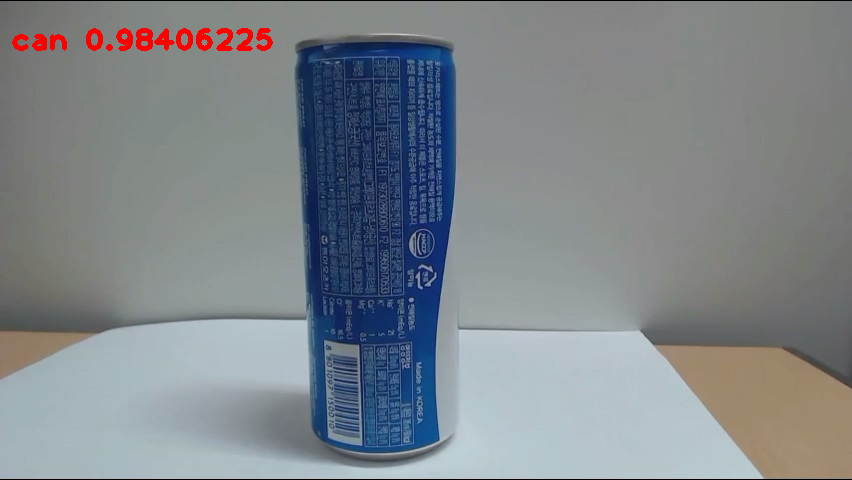

In [ ]:
# %cd /content
input_image_path = os.path.join(os.getcwd(), "test_image_1.jpg")
result = inference(input_image_path)